In [1]:
# Elvessa Tatum

## Introduction
 I plan on using the UCI Online Retail Dataset to discover patterns in customer 
purchasing behavior through Market Basket Analysis

In [2]:
import pandas as pd

retail_data = pd.read_csv('Online Retail.csv')
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
retail_data.info()
retail_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


##  2. Data Cleaning

In [4]:
# checking missing values
missing = retail_data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)

CustomerID     135080
Description      1454
dtype: int64


In [5]:
# drop missing InvoiceNo or Description
retail_data.dropna(subset=['InvoiceNo', 'Description'], inplace=True)

# remove canceled transactions (InvoiceNo starting with 'C')
retail_data = retail_data[~retail_data['InvoiceNo'].astype(str).str.startswith('C')]

In [6]:
# keep only popular products (bought more than 20 times)
popular_items = retail_data['Description'].value_counts()[retail_data['Description'].value_counts() > 20].index
retail_data = retail_data[retail_data['Description'].isin(popular_items)]

# randomly sample 2000 invoices (optional, safe)
sample_invoices = retail_data['InvoiceNo'].drop_duplicates().sample(2000, random_state=1)
retail_data = retail_data[retail_data['InvoiceNo'].isin(sample_invoices)]

## 3. Making Baskets and running Apriori

In [7]:
# create the basket
basket = retail_data.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)

# convert to 1/0
basket = (basket > 0).astype(bool)  # use bool type for better performance

In [8]:
from mlxtend.frequent_patterns import apriori, association_rules
# apply Apriori algorithm
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# filter for high-confidence rules
filtered_rules = rules[(rules['confidence'] >= 0.9) & (rules['lift'] >= 1.2)].copy()

filtered_rules['antecedents'] = filtered_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
filtered_rules['consequents'] = filtered_rules['consequents'].apply(lambda x: ', '.join(list(x)))

# print clean results
print(filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

                                            antecedents  \
296                            COFFEE MUG PEARS  DESIGN   
583                                   HERB MARKER BASIL   
584                                 HERB MARKER PARSLEY   
588                                   HERB MARKER BASIL   
590                                 HERB MARKER CHIVES    
...                                                 ...   
3567          HERB MARKER PARSLEY, HERB MARKER ROSEMARY   
3568             HERB MARKER PARSLEY, HERB MARKER THYME   
3571                                HERB MARKER PARSLEY   
3603  JUMBO BAG WOODLAND ANIMALS, JUMBO BAG APPLES, ...   
3673  JUMBO BAG WOODLAND ANIMALS, JUMBO SHOPPER VINT...   

                                            consequents  support  confidence  \
296                            COFFEE MUG APPLES DESIGN   0.0100    0.952381   
583                                    HERB MARKER MINT   0.0105    0.913043   
584                                   HERB MARKER B

## 4. Visualization and evaluation

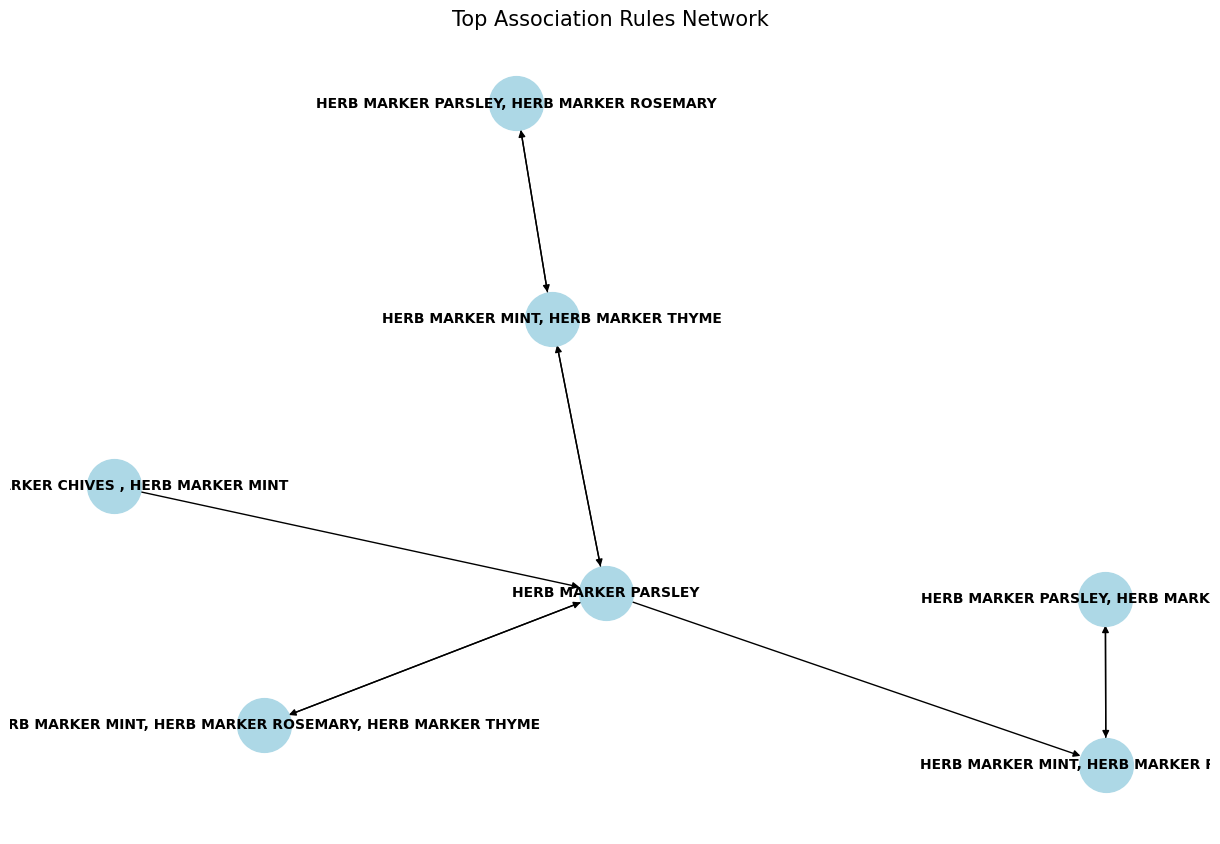

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# pick top 10 rules to visualize
top_rules = filtered_rules.sort_values('lift', ascending=False).head(10)

# create graph
G = nx.DiGraph()

for idx, row in top_rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['lift'])



plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, k=2)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)
plt.title("Top Association Rules Network", fontsize=15)
plt.show()

In [10]:
top_10_rules = filtered_rules.sort_values(by='lift', ascending=False).head(10)

print("\nTop 10 Rules by Lift:")
print(top_10_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Top 10 Rules by Lift:
                                            antecedents  \
3565             HERB MARKER MINT, HERB MARKER ROSEMARY   
3566                HERB MARKER MINT, HERB MARKER THYME   
3567          HERB MARKER PARSLEY, HERB MARKER ROSEMARY   
3568             HERB MARKER PARSLEY, HERB MARKER THYME   
2361                HERB MARKER MINT, HERB MARKER THYME   
3562  HERB MARKER MINT, HERB MARKER ROSEMARY, HERB M...   
3571                                HERB MARKER PARSLEY   
2364                                HERB MARKER PARSLEY   
2358                                HERB MARKER PARSLEY   
2348              HERB MARKER CHIVES , HERB MARKER MINT   

                                            consequents  support  confidence  \
3565             HERB MARKER PARSLEY, HERB MARKER THYME   0.0100    1.000000   
3566          HERB MARKER PARSLEY, HERB MARKER ROSEMARY   0.0100    0.952381   
3567                HERB MARKER MINT, HERB MARKER THYME   0.0100    1.000000   
3568   

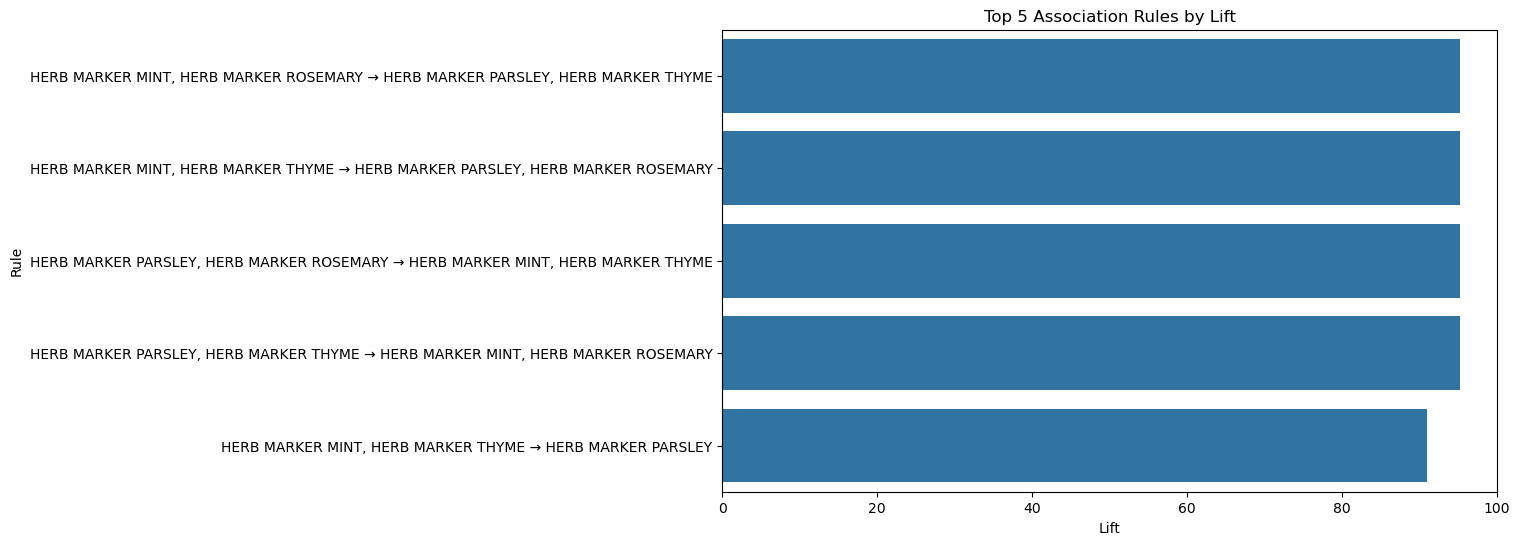

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# top 5 rules for graphing

top_5_rules = top_10_rules.head(5)

plt.figure(figsize=(10,6))
sns.barplot(
    x='lift', 
    y=top_5_rules['antecedents'].astype(str) + " → " + top_5_rules['consequents'].astype(str),
    data=top_5_rules
)
plt.title('Top 5 Association Rules by Lift')
plt.xlabel('Lift')
plt.ylabel('Rule')
plt.show()

## Conclusion:
 The strongest association rules found involved combinations of HERB MARKER products.
 These items often appeared together in transactions, showing very high confidence (≥ 0.9)
 and lift values above 90 — indicating strong market basket relationships.
 This suggests potential bundling or promotion opportunities.
